# Study pairing by dR(dijet, fatjet)

### Post-process Data and MC samples

- Sum all MC samples that belong to the same process
- Scale the number of events by the total sum of weights

In [1]:
# import utilities for post-process
import utils
import numpy as np

import matplotlib.pyplot as plt
import hist
import mplhep

import pandas as pd
import vector

In [2]:
samples = {
    "hh4b": ["GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8"],
}

# define dictionary with directories of files (this can be configured in a yaml file later in the script)

# this is the directory to the files
path_to_dir = "/eos/uscms/store/user/cmantill/bbbb/matching/Oct10"
dirs = {path_to_dir: samples}
year = "2018"

In [3]:
filters = [
    [
        ("('ak8FatJetPt', '0')", ">=", 300),
        ("('ak8FatJetMsd', '0')", ">=", 60),
        ("('ak8FatJetPNetXbb', '0')", ">=", 0.975),
        ("('ak8FatJetPNetXbb', '1')", "<", 0.975),
    ]
]


In [4]:
# columns to load
# the parquet files are too big so we can only load a few columns at a time without consumming much memory
load_columns = [
    ("weight", 1),
    ("ak4JetPt", 4),
    ("ak4JetPhi", 4),
    ("ak4JetEta", 4),
    ("ak4JetMass", 4),
    ("ak4JetbtagDeepFlavB", 4),
    ("ak4Pair0", 2),
    ("ak4Pair1", 2),
    ("ak8FatJetPt", 2),
    ("ak8FatJetEta", 2),
    ("ak8FatJetPhi", 2),
    ("ak8FatJetPNetMass", 2),
    ("ak8FatJetPNetXbb", 2),
]
# reformat into ("column name", "idx") format for reading multiindex columns
columns = []
for key, num_columns in load_columns:
    for i in range(num_columns):
        columns.append(f"('{key}', '{i}')")

In [5]:
# dictionary that will contain all information (from all samples)
events_dict = {}
for input_dir, samples in dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(input_dir, samples, year, filters=filters, columns=columns)
	}

Loading GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8
/eos/uscms/store/user/cmantill/bbbb/matching/Oct10/2018/GluGlutoHHto4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/parquet


In [6]:
# this will be the weight that will be stored in the eventsDict once the utils.loadSamples function is done
weight_key = ["finalWeight"]

In [7]:
samples_loaded = list(events_dict.keys())
keys_loaded = list(events_dict[samples_loaded[0]].keys())
print(f"Keys in events_dict {keys_loaded}")  

Keys in events_dict [('weight', 0), ('ak4JetPt', 0), ('ak4JetPt', 1), ('ak4JetPt', 2), ('ak4JetPt', 3), ('ak4JetPhi', 0), ('ak4JetPhi', 1), ('ak4JetPhi', 2), ('ak4JetPhi', 3), ('ak4JetEta', 0), ('ak4JetEta', 1), ('ak4JetEta', 2), ('ak4JetEta', 3), ('ak4JetMass', 0), ('ak4JetMass', 1), ('ak4JetMass', 2), ('ak4JetMass', 3), ('ak4JetbtagDeepFlavB', 0), ('ak4JetbtagDeepFlavB', 1), ('ak4JetbtagDeepFlavB', 2), ('ak4JetbtagDeepFlavB', 3), ('ak4Pair0', 0), ('ak4Pair0', 1), ('ak4Pair1', 0), ('ak4Pair1', 1), ('ak8FatJetPt', 0), ('ak8FatJetPt', 1), ('ak8FatJetEta', 0), ('ak8FatJetEta', 1), ('ak8FatJetPhi', 0), ('ak8FatJetPhi', 1), ('ak8FatJetPNetMass', 0), ('ak8FatJetPNetMass', 1), ('ak8FatJetPNetXbb', 0), ('ak8FatJetPNetXbb', 1), ('weight_nonorm', ''), ('finalWeight', '')]


## Get additional variables for event selection

In [8]:
def make_vector(events: pd.DataFrame, obj: str):
    """Create a ``vector`` object from the columns of the dataframe"""
    mstring = "PNetMass" if obj == "ak8FatJet" else "Mass"

    return vector.array(
        {
            "pt": events[f"{obj}Pt"],
            "phi": events[f"{obj}Phi"],
            "eta": events[f"{obj}Eta"],
            "M": events[f"{obj}{mstring}"],
        }
    )

In [9]:
jets = make_vector(events_dict["hh4b"], "ak4Jet")
fatjets = make_vector(events_dict["hh4b"], "ak8FatJet")

In [10]:
# array with length 
np.arange(len(jets.pt))

array([    0,     1,     2, ..., 23911, 23912, 23913])

In [11]:
events_dict["hh4b"].ak4Pair0[0].to_numpy()

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
events_dict["hh4b"].ak4Pair0.to_numpy()

array([[0, 1],
       [0, 2],
       [0, 3],
       ...,
       [0, 1],
       [0, 3],
       [0, 2]])

In [13]:
events_dict["hh4b"].ak4Pair0.to_numpy()[:, 0]

array([0, 0, 0, ..., 0, 0, 0])

In [14]:
first_bb_pair = events_dict["hh4b"].ak4Pair0.to_numpy()
second_bb_pair = events_dict["hh4b"].ak4Pair1.to_numpy()

first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

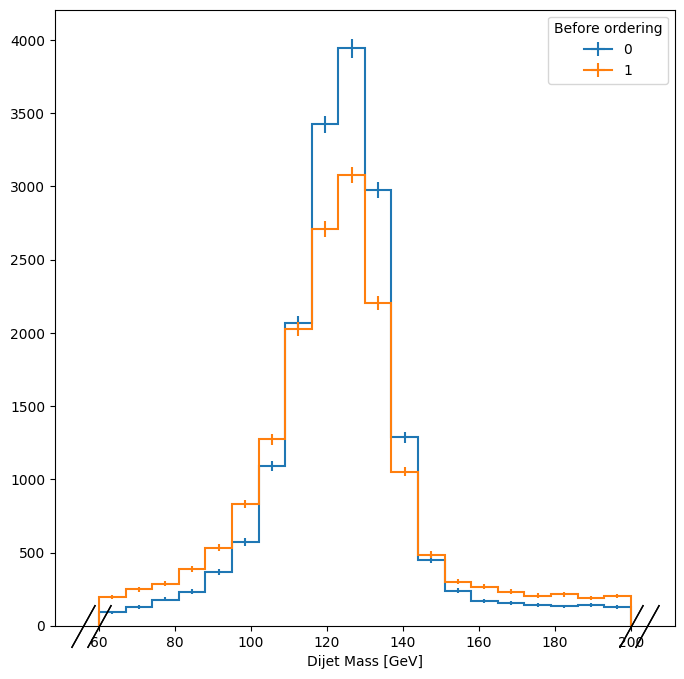

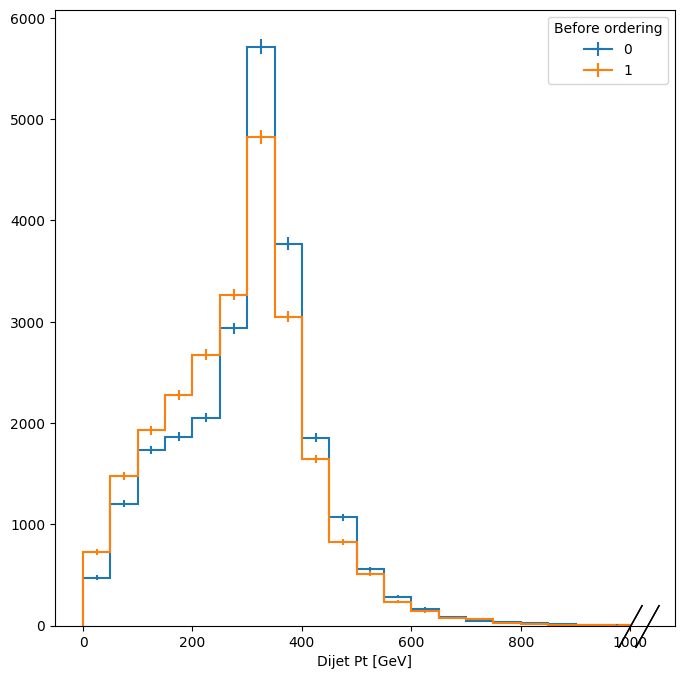

In [15]:
dijet_mass_axis = hist.axis.Regular(20, 60, 200, name="dijet_mass", label="Dijet Mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=first_bb_dijet.mass, pair="0")
h.fill(dijet_mass=second_bb_dijet.mass, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="Before ordering")

dijet_pt_axis = hist.axis.Regular(20, 0, 1000, name="dijet_pt", label="Dijet Pt [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_pt_axis, pair_axis)
h.fill(dijet_pt=first_bb_dijet.pt, pair="0")
h.fill(dijet_pt=second_bb_dijet.pt, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="Before ordering")

In [16]:
# stack pairs
bb_pairs = np.stack([first_bb_pair, second_bb_pair], axis=1)

# sort by dijet pt
bbs_jjpt = np.concatenate(
    [first_bb_dijet.pt.reshape(-1, 1), second_bb_dijet.pt.reshape(-1, 1)], axis=1
)
sort_by_jjpt = np.argsort(bbs_jjpt, axis=-1)[:, ::-1]

bb_pairs_sorted = np.array(
    [
        [bb_pair_e[sort_e[0]], bb_pair_e[sort_e[1]]]
        for bb_pair_e, sort_e in zip(bb_pairs, sort_by_jjpt)
    ]
)

first_bb_pair_sort = bb_pairs_sorted[:, 0]
second_bb_pair_sort = bb_pairs_sorted[:, 1]


first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

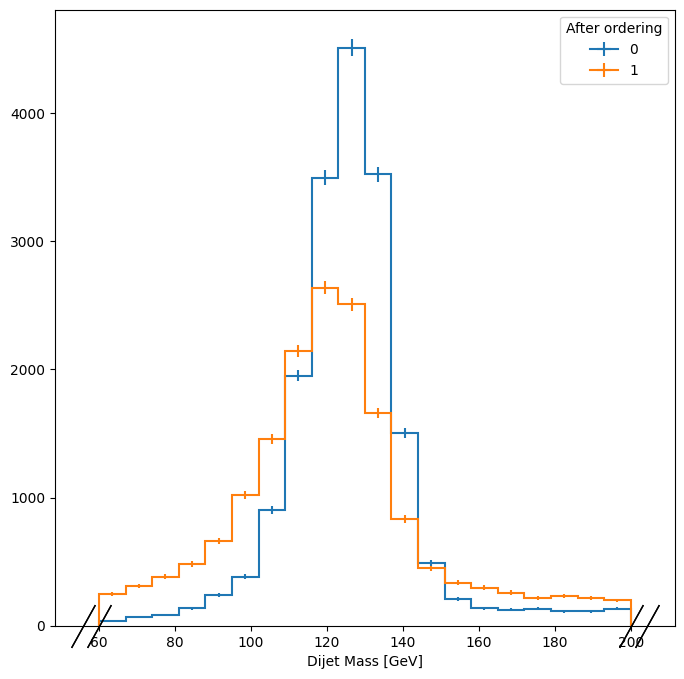

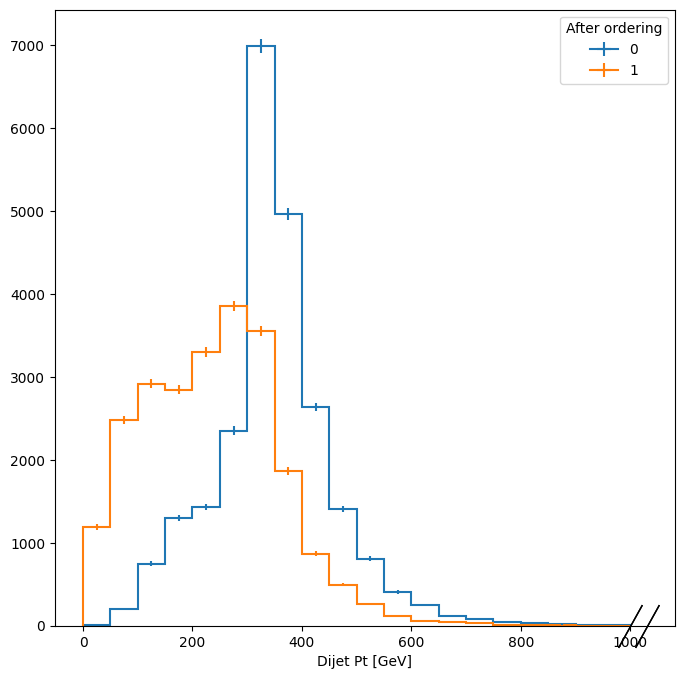

In [17]:
dijet_mass_axis = hist.axis.Regular(20, 60, 200, name="dijet_mass", label="Dijet Mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=first_bb_dijet.mass, pair="0")
h.fill(dijet_mass=second_bb_dijet.mass, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="After ordering")

dijet_pt_axis = hist.axis.Regular(20, 0, 1000, name="dijet_pt", label="Dijet Pt [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_pt_axis, pair_axis)
h.fill(dijet_pt=first_bb_dijet.pt, pair="0")
h.fill(dijet_pt=second_bb_dijet.pt, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="After ordering")


Text(0.5, 1.0, '$\\Delta R$ between pairs')

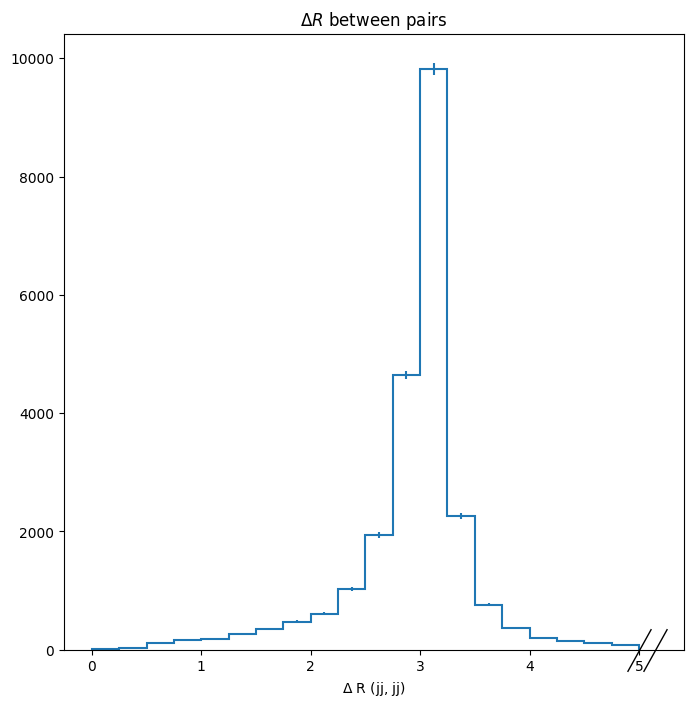

In [18]:
# get delta r between pairs
deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, jj)")
h = hist.Hist(deltar_axis)
h.fill(deltar=first_bb_dijet.deltaR(second_bb_dijet))

fig, ax = plt.subplots(figsize=(8, 8))
h.plot1d()
ax.set_title(r"$\Delta R$ between pairs")

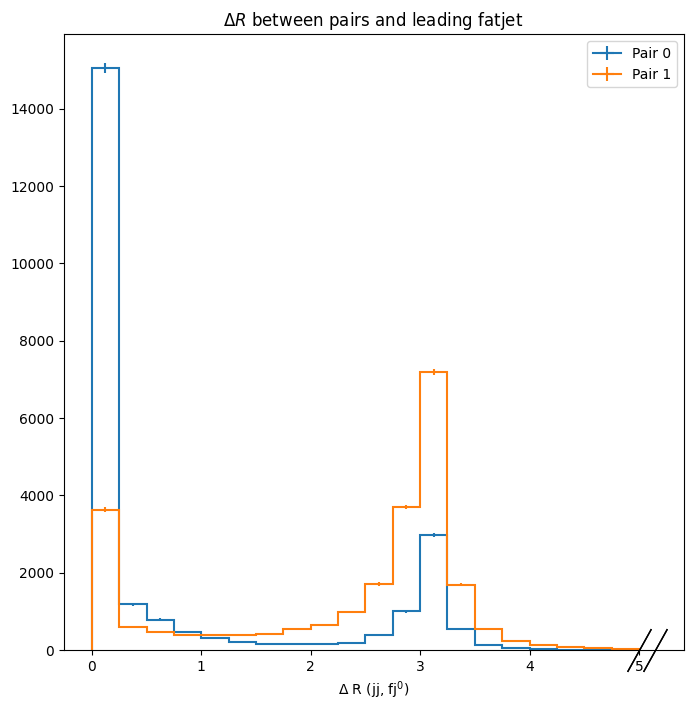

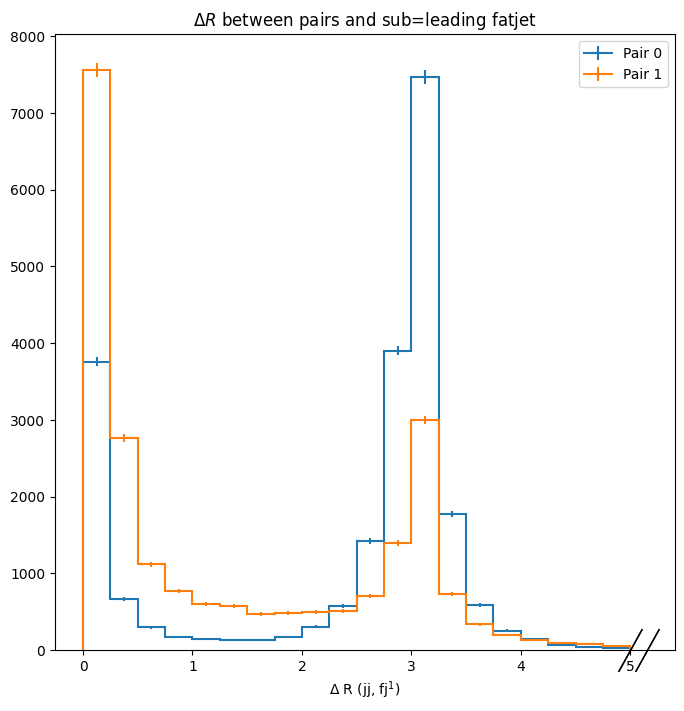

In [19]:
# get delta r between pairs and fatjets
fatjet_0 = fatjets[:, 0]
fatjet_1 = fatjets[:, 1]

deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, fj$^0$)")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)
h = hist.Hist(deltar_axis,pair_axis)
h.fill(deltar=first_bb_dijet.deltaR(fatjet_0), pair="0")
h.fill(deltar=second_bb_dijet.deltaR(fatjet_0), pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": 0}].plot1d(label="Pair 0", ax=ax)
h[{"pair": 1}].plot1d(label="Pair 1", ax=ax)
ax.set_title(r"$\Delta R$ between pairs and leading fatjet")
ax.legend()

deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, fj$^1$)")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)
h = hist.Hist(deltar_axis,pair_axis)
h.fill(deltar=first_bb_dijet.deltaR(fatjet_1), pair="0")
h.fill(deltar=second_bb_dijet.deltaR(fatjet_1), pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": 0}].plot1d(label="Pair 0", ax=ax)
h[{"pair": 1}].plot1d(label="Pair 1", ax=ax)
ax.set_title(r"$\Delta R$ between pairs and sub=leading fatjet")
ax.legend()


In [20]:
fatjet_0 = fatjets[:, 0]

first_bb_pair = events_dict["hh4b"].ak4Pair0.to_numpy()
second_bb_pair = events_dict["hh4b"].ak4Pair1.to_numpy()
first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

# stack pairs
bb_pairs = np.stack([first_bb_pair, second_bb_pair], axis=1)

# sort by deltaR with leading fatjet
bbs_dRfj = np.concatenate(
    [first_bb_dijet.deltaR(fatjet_0).reshape(-1, 1), second_bb_dijet.deltaR(fatjet_0).reshape(-1, 1)], axis=1
)
# sort from larger dR to smaller
sort_by_dR = np.argsort(-bbs_dRfj, axis=-1)

bb_pairs_sorted = np.array(
    [
        [bb_pair_e[sort_e[0]], bb_pair_e[sort_e[1]]]
        for bb_pair_e, sort_e in zip(bb_pairs, sort_by_dR)
    ]
)

first_bb_pair_sort = bb_pairs_sorted[:, 0]
second_bb_pair_sort = bb_pairs_sorted[:, 1]


first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 0]]
first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 1]]
first_bb_dijet = first_bb_j1 + first_bb_j2

second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 0]]
second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 1]]
second_bb_dijet = second_bb_j1 + second_bb_j2

In [21]:
bbs_dRfj

array([[1.13339657e-02, 3.06704835e+00],
       [1.47257093e-02, 2.90357684e+00],
       [3.09705056e+00, 1.78441239e-03],
       ...,
       [2.05081329e-01, 3.28867136e+00],
       [3.15192780e+00, 1.57784343e-02],
       [7.56880034e-01, 3.16155814e+00]])

In [22]:
x = np.where(bbs_dRfj>0.8, bbs_dRfj, 0)
x[np.all(x == 0, axis=1)].shape

(232, 2)

In [23]:
sort_by_dR

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [0, 1],
       [1, 0]])

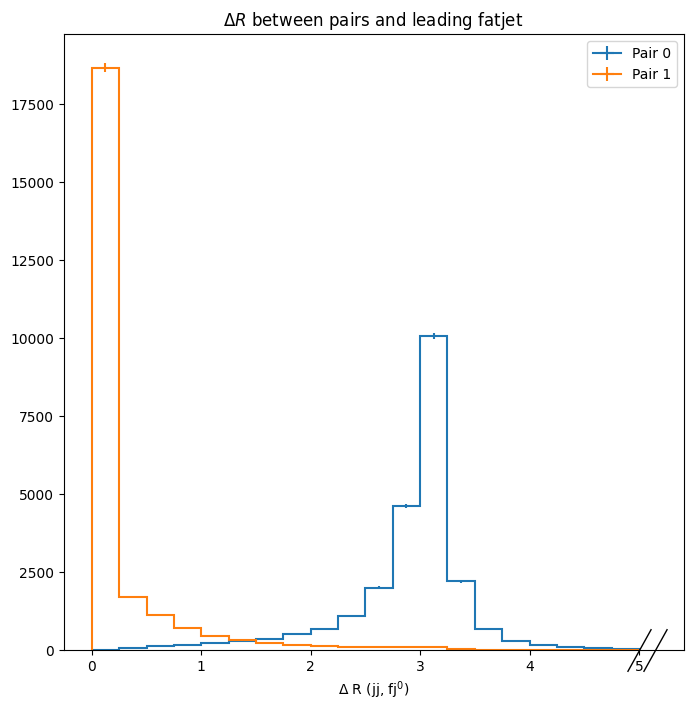

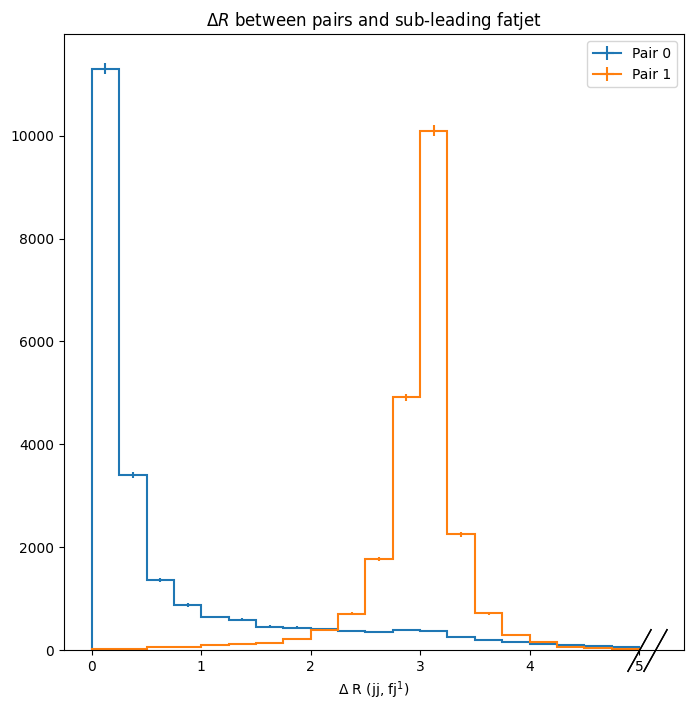

In [28]:
# get delta r between pairs and fatjets
fatjet_0 = fatjets[:, 0]
fatjet_1 = fatjets[:, 1]

deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, fj$^0$)")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)
h = hist.Hist(deltar_axis,pair_axis)
h.fill(deltar=first_bb_dijet.deltaR(fatjet_0), pair="0")
h.fill(deltar=second_bb_dijet.deltaR(fatjet_0), pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": 0}].plot1d(label="Pair 0", ax=ax)
h[{"pair": 1}].plot1d(label="Pair 1", ax=ax)
ax.set_title(r"$\Delta R$ between pairs and leading fatjet")
ax.legend()

deltar_axis = hist.axis.Regular(20, 0, 5, name="deltar", label=r"$\Delta$ R (jj, fj$^1$)")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)
h = hist.Hist(deltar_axis,pair_axis)
h.fill(deltar=first_bb_dijet.deltaR(fatjet_1), pair="0")
h.fill(deltar=second_bb_dijet.deltaR(fatjet_1), pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": 0}].plot1d(label="Pair 0", ax=ax)
h[{"pair": 1}].plot1d(label="Pair 1", ax=ax)
ax.set_title(r"$\Delta R$ between pairs and sub-leading fatjet")
ax.legend()

In [25]:
# choice of pair
dr_fatjet = first_bb_dijet.deltaR(fatjet_0)
mask_overlap = (dr_fatjet > 0.8)

print(dr_fatjet.shape)
print(dr_fatjet[mask_overlap].shape)

(23914,)
(23682,)


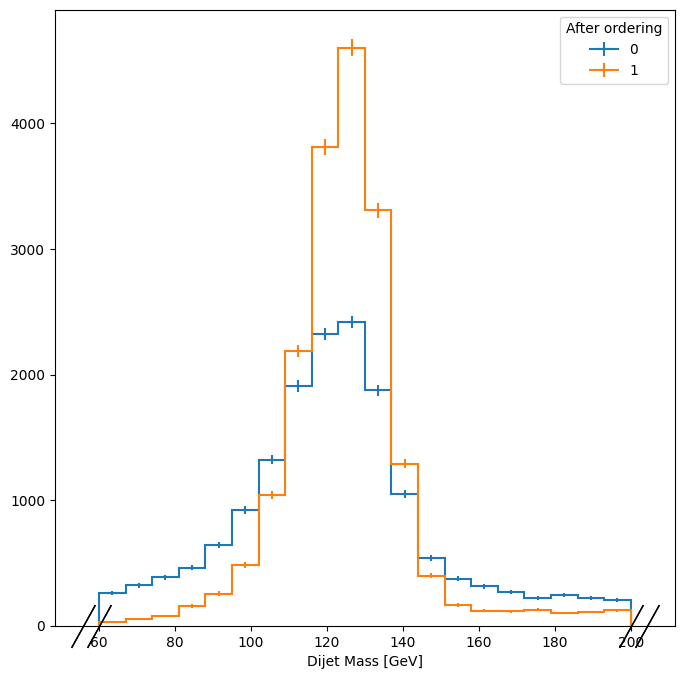

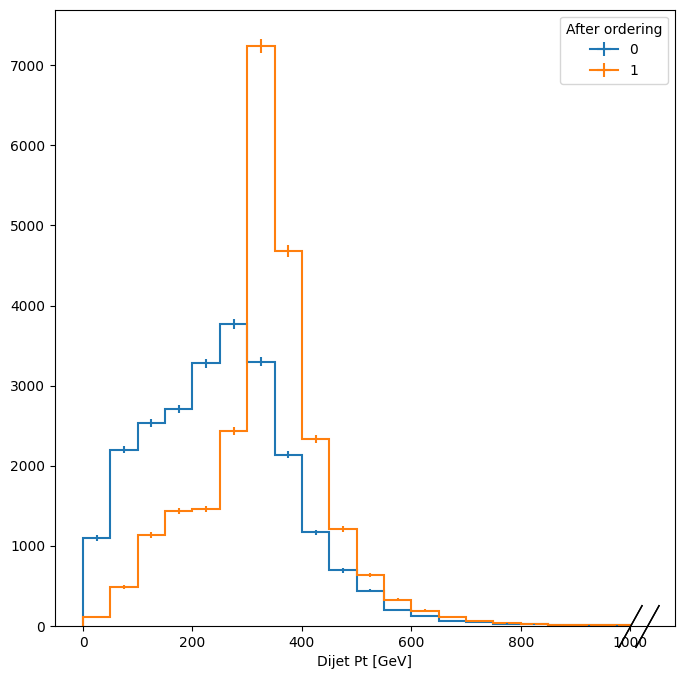

In [26]:
dijet_mass_axis = hist.axis.Regular(20, 60, 200, name="dijet_mass", label="Dijet Mass [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_mass_axis, pair_axis)
h.fill(dijet_mass=first_bb_dijet.mass, pair="0")
h.fill(dijet_mass=second_bb_dijet.mass, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="After ordering")

dijet_pt_axis = hist.axis.Regular(20, 0, 1000, name="dijet_pt", label="Dijet Pt [GeV]")
pair_axis = hist.axis.StrCategory([], name="pair", growth=True)

h = hist.Hist(dijet_pt_axis, pair_axis)
h.fill(dijet_pt=first_bb_dijet.pt, pair="0")
h.fill(dijet_pt=second_bb_dijet.pt, pair="1")

fig, ax = plt.subplots(figsize=(8, 8))
h[{"pair": "0"}].plot1d(label="0", ax=ax)
h[{"pair": "1"}].plot1d(label="1", ax=ax)
ax.legend(title="After ordering")

In [27]:
## make this into a function
def add_jet_variables(events):
    fatjets = make_vector(events, "ak8FatJet")
    jets = make_vector(events, "ak4Jet")
    jets_shape = np.arange(len(jets.pt))

    # get unordered pairs
    first_bb_pair = events.ak4Pair0.to_numpy()
    second_bb_pair = events.ak4Pair1.to_numpy()

    first_bb_j1 = jets[jets_shape, first_bb_pair[:, 0]]
    first_bb_j2 = jets[jets_shape, first_bb_pair[:, 1]]
    first_bb_dijet = first_bb_j1 + first_bb_j2

    second_bb_j1 = jets[jets_shape, second_bb_pair[:, 0]]
    second_bb_j2 = jets[jets_shape, second_bb_pair[:, 1]]
    second_bb_dijet = second_bb_j1 + second_bb_j2

    # stack pairs
    bb_pairs = np.stack([first_bb_pair, second_bb_pair], axis=1)

    # sort by deltaR with leading fatjet
    bbs_dRfj = np.concatenate(
        [first_bb_dijet.deltaR(fatjet_0).reshape(-1, 1), second_bb_dijet.deltaR(fatjet_0).reshape(-1, 1)], axis=1
    )
    # sort from larger dR to smaller
    sort_by_dR = np.argsort(-bbs_dRfj, axis=-1)

    bb_pairs_sorted = np.array(
        [
            [bb_pair_e[sort_e[0]], bb_pair_e[sort_e[1]]]
            for bb_pair_e, sort_e in zip(bb_pairs, sort_by_dR)
        ]
    )

    # get sorted pairs
    first_bb_pair_sort = bb_pairs_sorted[:, 0]
    second_bb_pair_sort = bb_pairs_sorted[:, 1]

    first_bb_j1 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 0]]
    first_bb_j2 = jets[np.arange(len(jets.pt)), first_bb_pair_sort[:, 1]]
    first_bb_dijet = first_bb_j1 + first_bb_j2

    second_bb_j1 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 0]]
    second_bb_j2 = jets[np.arange(len(jets.pt)), second_bb_pair_sort[:, 1]]
    second_bb_dijet = second_bb_j1 + second_bb_j2

    dr_fatjet = first_bb_dijet.deltaR(fatjets[:, 0])

    new_vars = {
        "ak4DijetPt": first_bb_dijet.pt,
        "ak4DijetMass": first_bb_dijet.pt,
        "ak4DijetdRFatJet": dr_fatjet
    }

    return {**events,
            **new_vars}